### 遗传算法解混合流水车间调度问题
- 此处测试样例：6个工件，3个工序，每个工序有2台机器


In [1]:
from itertools import permutations
import numpy as np
import random
import math
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 0.算法参数

In [2]:
params={
    "num_work":6,
    "num_process":3,
    "num_machine":2,
    "file":"input.txt",
    # GA参数
    "num_group":20,# 种群数
    "prob_cross":0.6,# 交叉率
    "prob_mutate":0.05 # 变异率
}

## 1.读取样例
- $ p[i][j]$:第$i$个工件第$j$个工序用时

In [3]:
def read_for_p(file):
    f=open(file,"r")
    p=[[0]*params["num_process"] for _ in range(params["num_work"])]
    for index,lines in enumerate(f.readlines()):
        line=lines.split()
        p[index]=list(map(int,line))
    return p

In [4]:
p=read_for_p(params["file"])

## 2.定义GA类
- enconding ： 编码是工件的优先级别的排列
- decoding：一个编码所对应的完成时间
- fitness ： 解码后的适应度
- choose： 选择进入下一代，轮盘赌
- cross ： 交叉，选择父代1与父代2，
    > 子代1交叉点继承父代2内排列，交叉点外剩余顺序继承父代1。子代2相反
    
    > father1: 14|653|72, father2: 26|371|45
    
    > son1 : 46|371|52  ,son2: 27|653|14
    
- mutate：变异
    > 采用两点变异的方式，随机生成两个基因位，并交换两个基因位上的基因。

In [10]:
class GA_solve_HFSSP:
    def __init__(self,params):
        # GA参数
        self.num_group=params["num_group"]
        self.prob_cross=params["prob_cross"]
        self.prob_mutate=params["prob_mutate"]
        # 车间参数
        self.num_work=params["num_work"]
        self.num_process=params["num_process"]
        self.num_machine=params["num_machine"]
        
    def __encoding(self,num_group,num_work):
        """
        初始化数量为num_group的一个种群，个体为长度是num_work的全排列。
        不使用list(permutations) 的原因是因为他的初始种群都是一样的，
        加np.random.shuffle，对于工件数很多（>30）的时候，内存肯定会爆。
        """
        group=[]
        if num_group>math.factorial(num_work)*0.7:
            print("num_group过大")
            raise ValueErroe
        while len(group)!=num_group:
            a=random.sample(range(num_work),num_work)
            if a not in group:
                group.append(a)
        return group

    def decoding(self,gene):
        """
        对于每个个体(排列)，解码出他的完成时间
        gene:是当前排列顺序
        """
        num_process=self.num_process
        num_machine=self.num_machine
        num_work=len(gene)
        machine_time=[0 for _ in range(num_machine)] #记录每个machine结束的时间
        gene_time=[0 for _ in range(num_work)]
        # 每一步的时间消耗
        def step(gene,machine_time,gene_time,stepnum):
            machine_time=[0 for _ in range(num_machine)] #记录每个machine结束的时间
            for i in range(len(gene)):
                index=machine_time.index(min(machine_time)) # 找到最空闲的machine
                # 在这个machine上做工件i 的 工序J
                machine_time[index]=max(machine_time[index],gene_time[ gene[i] ])+p[gene[i]][stepnum]
                # 记录这个工件i 的完成时间
                gene_time[ gene[i] ]=machine_time[index]                
            return machine_time,gene_time
        
        for j in range(num_process):
            machine_time,gene_time = step(gene,machine_time,gene_time,j)
            # 每次工序都要重新排序记录优先处理排列顺序
            gene=[idx for idx,value in sorted(enumerate(gene_time),key=lambda x:x[1])]
        total_time=max(machine_time)
        return total_time
    
    def __fitness(self,time_list):
        """
        适应度取1/(1+x)
        """
        a=np.array(list(map(lambda x:1/(x),time_list)))
        return a/sum(a)
    
    def __choose(self,fitness_list,group_list):
        """
        选择两个父代（按照轮盘赌的方式）
        两个父代不一样。
        """
        a,b=np.random.choice(range(len(group_list)),2,replace=False,p=fitness_list)
        return (group_list[a],group_list[b])
    
    def __cross(self,sample_tuple):
        """
        随机两点，进行交叉
        子代1交叉点继承父代2内排列，交叉点外剩余顺序继承父代1。子代2相反
        """
        a,b=sample_tuple
        assert len(a)==self.num_work
        
        index1,index2=sorted(np.random.choice(range(self.num_work),2,replace=False))
        new_a,new_b=b[index1:index2+1],a[index1:index2+1]
        dict_a,dict_b=set(b[index1:index2+1]),set(a[index1:index2+1])
        count_a,count_b=0,0
        for index,value in enumerate(a):
            if value not in dict_a:
                if count_a<index1:
                    new_a.insert(count_a,value)
                    count_a +=1
                else:
                    new_a.append(value)
        for index,value in enumerate(b):
            if value not in dict_b:
                if count_b<index1:
                    new_b.insert(count_b,value)
                    count_b+=1
                else:
                    new_b.append(value)      
        return new_a,new_b
        
    def __mutate(self,gene):
        gene_new=deepcopy(gene)
        index1,index2=sorted(np.random.choice(range(self.num_work),2,replace=False))
        gene_new[index1],gene_new[index2]=gene_new[index2],gene_new[index1]
        return gene_new
    
    def fit(self):
        self.group=self.__encoding(self.num_group,self.num_work)
        self.deco=list(map(self.decoding,self.group))
        best_time=min(self.deco)
        best_seq=self.group[self.deco.index(min(self.deco))]

        for epoch in range(300):            
            self.fitness=self.__fitness(self.deco)            
            self.new_group=[]
            while len(self.new_group)<self.num_group:
                self.sample=self.__choose(self.fitness,self.group)
                cross_seed=random.randint(0,100)
                if cross_seed<self.prob_cross*100:
                    self.son=self.__cross(self.sample)
                else:
                    self.son=self.sample
                mutate_seed=random.randint(0,100)
                if mutate_seed<self.prob_mutate*100:
                    self.mute=list(map(self.__mutate,self.son))
                else:
                    self.mute=self.son

                self.new_group.extend(deepcopy(self.mute))
            self.group=self.new_group
            self.deco=list(map(self.decoding,self.group))
            
            temp=min(self.deco)
            temp_seq=self.group[self.deco.index(temp)]
            if temp<best_time:
                best_time=temp
                best_seq=deepcopy(temp_seq)

        best_seq1=list(map(lambda x:x+1,best_seq))
        print("最优时间:",best_time)
        print("最优顺序:",best_seq1)
        self.gante(best_seq1)
        return best_time,best_seq1
    
    def gante(self,seq):
        ## decoding
        seq=list(map(lambda x:x-1,seq))
        num_process=self.num_process
        num_machine=self.num_machine
        num_work=self.num_work
        def decode(gene):
            machine_record=[]
            gene_record=[]
            use_record=[]

            machine_time=[0 for _ in range(num_machine)] #记录每个machine结束的时间
            gene_time=[0 for _ in range(num_work)]
            # 每一步的时间消耗
            def step(gene,machine_time,gene_time,stepnum):
                machine_use=[[],[]]
                machine_time=[0 for _ in range(num_machine)] #记录每个machine结束的时间
                for i in range(len(gene)):
                    index=machine_time.index(min(machine_time)) # 找到最空闲的machine
                    machine_use[index].append(gene[i])
                    # 在这个machine上做工件i 的 工序J
                    machine_time[index]=max(machine_time[index],gene_time[ gene[i] ])+p[gene[i]][stepnum]
                    # 记录这个工件i 的完成时间
                    gene_time[ gene[i] ]=machine_time[index]                
                return machine_time,gene_time,machine_use

            for j in range(num_process):

                machine_time,gene_time,machine_use = step(gene,machine_time,gene_time,j)

                machine_record.append(machine_time)
                gene_record.append(deepcopy(gene_time))
                use_record.append(deepcopy(machine_use))
                # 每次工序都要重新排序记录优先处理排列顺序
                gene=[idx for idx,value in sorted(enumerate(gene_time),key=lambda x:x[1])]
            total_time=max(machine_time)

            return machine_record,gene_record,use_record

        machine_record,gene_record,use_record=decode(seq)
        color = ['b','g','r','y','c','m','k','peachpuff','limegreen','lightpink']

        y,width,left,color_list,label_list=[],[],[],[],[]
        for index1,value1 in enumerate(use_record): ## index1 工序-1
            for index2,value2  in enumerate(value1): ## index2 机器-1
                for j in value2: ## j 工件
                    ## 构造y
                    y.append(num_process*num_machine-index1*2-index2)
                    ## 构造width
                    width.append(p[j][index1])
                    ## 构造left
                    left.append(gene_record[index1][j]-p[j][index1])
                    ## 构造color  
                    color_list.append(color[j])
                    word="工序{}机器{}".format(index1+1,index2+1)
                    if word not in label_list:
                        label_list.append(word)
                    else:
                        label_list.append("")
        import matplotlib.pyplot as plt
        
 
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
        plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
        plt.figure(figsize=(15,num_process*num_machine),dpi=80)
        plt.barh(y,width,left=left,color=color_list,tick_label=label_list)#绘制水平直方图
        labels =["工件%d"%(f+1) for f in range(num_work)]
        patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(num_work) ]
        plt.legend(handles=patches,loc=1)
    #     plt.grid(linestyle="--",alpha=0.5)
        #XY轴标签
        plt.xlabel("加工时间/s")
        plt.ylabel("")
        plt.show()#显示图像


最优时间: 25
最优顺序: [5, 4, 1, 2, 6, 3]


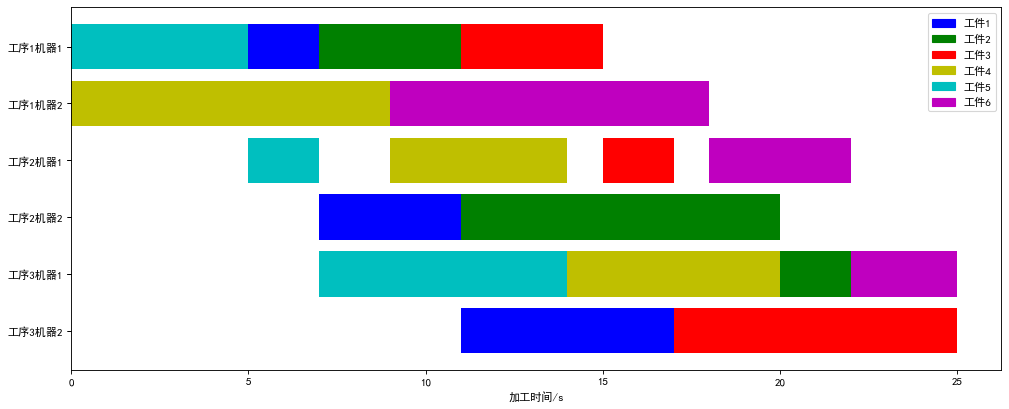

In [12]:
test=GA_solve_HFSSP(params)
best_time,best_seq=test.fit()